In [1]:
import numpy as np

In [2]:
pwd

'C:\\Python Files\\AluminaConcEstimator\\NoteBooks'

In [3]:
import sys
sys.path.append('../')

In [4]:
from Refactor.Properties import ValidProperty, CellProperties
from Refactor.Model import VariableVector, ControlMatrix, clone_vector
from Refactor.CellVoltage import VIcell
from numpy.linalg import inv
from scipy.linalg import cholesky, LinAlgError

In [5]:
# Need to define the cell first
bbcell = CellProperties()

In [6]:
# need to extract gamma to define the control matrices - it has dependency on a valid CE
gamma, validg = bbcell.gamma
print(gamma, validg)

1.664337575188073e-05 True


In [7]:
# Create initial State Vector Variables
x0 = VariableVector(cAl2O3=3.5, deltag=9.0, ACD=2.9193, deltaI=0.0)
x0.dictionary

{'cAl2O3': 0, 'deltag': 1, 'ACD': 2, 'deltaI': 3}

In [8]:
# Create Input Vector Variables
u0 = VariableVector(g0=0.0, B=0.0, I0=126000.0, )
u0.dictionary

{'g0': 0, 'B': 1, 'I0': 2}

In [9]:
# Create Measurement Vector Variables
z0 = VariableVector(Vcell=4.465858, Icell=126000.0)
z0.dictionary

{'Vcell': 0, 'Icell': 1}

### Removed delta_I dependency on previous value

In [10]:
# Define the F matrix for 4 state model with first order dependency on dT
F = ControlMatrix(4, 4, 1)
# Identity matrix for the terms independent of dT, except the delta I term
F0 = np.identity(4, dtype=float)
F0[3, 3] = 0.0
F.set_array_layer(0, F0)

True

### Corrected 2nd term first row for dimensional consistency and conservation of mass

In [11]:
# first order dependency on dT in layer 1
F.set_array_layer(1, np.array([[0.0, 100*bbcell.kdiss/bbcell.m, 0.0, -gamma/bbcell.m],
                               [0.0, -bbcell.kdiss, 0.0, 0.0],
                               [0.0, 0.0, 0.0, bbcell.alpha],
                               [0.0, 0.0, 0.0, 0.0]]))

True

In [12]:
# evaluate F with dT = 5 sec
F.array_eval(5)

array([[ 1.00000000e+00,  5.55555556e-04,  0.00000000e+00,
        -4.62315993e-08],
       [ 0.00000000e+00,  9.90000000e-01,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        -1.64690382e-10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [13]:
# Simple noise model - dT terms on the diagonal
G = ControlMatrix(4, 4, 1)
G.set_array_layer(0, np.zeros((4,4)))
G.set_array_layer(1, np.identity(4, dtype=float))

True

In [14]:
# evaluate G with dT = 5 sec
G.array_eval(5)

array([[5., 0., 0., 0.],
       [0., 5., 0., 0.],
       [0., 0., 5., 0.],
       [0., 0., 0., 5.]])

### Corrected first element for dimensional consistency (wt%)

In [15]:
# input control matrix for 4 states, 3 inputs so it is 4 x 3
B = ControlMatrix(4, 3, 1)
B.set_array_layer(0, np.array([[100/bbcell.m, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]))
B.set_array_layer(1, np.array([[0.0, 0.0, -gamma/bbcell.m], [0.0, 0.0, 0.0], [0.0, 0.0, bbcell.alpha], [0.0, 0.0, 0.0]]))

True

In [16]:
# evaluate B with dT = 5 sec
B.array_eval(5)

array([[ 5.55555556e-02,  0.00000000e+00, -4.62315993e-08],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00, -1.64690382e-10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [17]:
# Define the UKF noise standard deviations - needed to back off on first 2 states for simulation
q1std = 0.00002    # 0.0002 alumina concentration variation (wt%)
q2std = 0.02       # 0.2 alumina feed mass discrepancy (kg)
q3std = 0.0000001  # 0.0000001 acd varation needs to be much lower (cm)
q4std = 30         # 30 deltaI varation is measured in (amps)
Q = ControlMatrix(4, 4, 0)
Q.set_array_layer(0, np.array([[q1std**2, 0.0, 0.0, 0.0],
                               [0.0, q2std**2, 0.0, 0.0],
                               [0.0, 0.0, q3std**2, 0.0],
                               [0.0, 0.0, 0.0, q4std**2]]))
Q.array_display

array([[[4.e-10, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 4.e-04, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-14, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 9.e+02]]])

In [18]:
# Define the measurement standard deviations
r1std = 0.0010      # 0.001 measurement variation (volts)
r2std = 20          # 50 measurement variation (amps)
R = ControlMatrix(2, 2, 0)
R.set_array_layer(0, np.array([[r1std**2, 0.0], [0.0, r2std**2]]))
R.array_display

array([[[1.e-06, 0.e+00],
        [0.e+00, 4.e+02]]])

In [19]:
from Refactor.UKFClass import DiscreteModel

In [20]:
alumina4state = DiscreteModel(F, B, G, Q, R, z0, u0, x0)

In [21]:
alumina4state.defined

True

In [22]:
alumina4state.x0.vector

array([[3.5   ],
       [9.    ],
       [2.9193],
       [0.    ]])

In [23]:
from Refactor.UKFClass import UKF, ukf_unpack, ukf_zpack

In [24]:
UKF4state = UKF(alumina4state, bbcell, x0, 5)

In [25]:
UKF4state.initialised

True

In [26]:
UKF4state.update_timestep(5)

False

In [27]:
UKF4state.Qm

array([[1.00e-08, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 1.00e-02, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 2.50e-13, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 2.25e+04]])

In [28]:
UKF4state.Rm

array([[1.e-06, 0.e+00],
       [0.e+00, 4.e+02]])

In [29]:
UKF4state.dT

5

In [30]:
# predict the state for next timestep using the current input and state vectors
UKF4state.predict_state(u0, 5)

True

In [31]:
UKF4state.uk.vector

array([[     0.],
       [     0.],
       [126000.]])

In [32]:
UKF4state.Ppred

array([[1.32345104e-06, 5.50000000e-04, 1.71312744e-11, 0.00000000e+00],
       [5.50000000e-04, 9.90100000e-01, 0.00000000e+00, 0.00000000e+00],
       [1.71312744e-11, 0.00000000e+00, 2.53110266e-11, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.25000000e+04]])

In [33]:
UKF4state.predictionflag

True

In [34]:
# the next timestep prediction
UKF4state.xpred.vector

array([[3.49917482],
       [8.91      ],
       [2.91927925],
       [0.        ]])

In [35]:
# calling the UKF method to see the UKF samples generated around xpred
UKF4state.ukf_gen_samples()

(True,
 array([[[   3.49917482],
         [   8.91      ],
         [   2.91927925],
         [   0.        ]],
 
        [[   3.50174722],
         [   9.9790395 ],
         [   2.91927928],
         [   0.        ]],
 
        [[   3.49660242],
         [   7.8409605 ],
         [   2.91927922],
         [   0.        ]],
 
        [[   3.49917482],
         [  10.86132123],
         [   2.91927923],
         [   0.        ]],
 
        [[   3.49917482],
         [   6.95867877],
         [   2.91927927],
         [   0.        ]],
 
        [[   3.49917482],
         [   8.91      ],
         [   2.9192905 ],
         [   0.        ]],
 
        [[   3.49917482],
         [   8.91      ],
         [   2.919268  ],
         [   0.        ]],
 
        [[   3.49917482],
         [   8.91      ],
         [   2.91927925],
         [ 335.41019662]],
 
        [[   3.49917482],
         [   8.91      ],
         [   2.91927925],
         [-335.41019662]]]),
 array([[[0.2]],
 
        [[0

In [36]:
# generate a new observation
z1 = clone_vector(z0)
z1.setvariable('Vcell', 4.47010343)
z1.setvariable('Icell', 126075)
z1.vector

array([[4.47010343e+00],
       [1.26075000e+05]])

In [37]:
# perform and update step with the new observation
UKF4state.update_state(z1)

True

In [38]:
UKF4state.xpredsamples

array([[[   3.49917482],
        [   8.91      ],
        [   2.91927925],
        [   0.        ]],

       [[   3.50174722],
        [   9.9790395 ],
        [   2.91927928],
        [   0.        ]],

       [[   3.49660242],
        [   7.8409605 ],
        [   2.91927922],
        [   0.        ]],

       [[   3.49917482],
        [  10.86132123],
        [   2.91927923],
        [   0.        ]],

       [[   3.49917482],
        [   6.95867877],
        [   2.91927927],
        [   0.        ]],

       [[   3.49917482],
        [   8.91      ],
        [   2.9192905 ],
        [   0.        ]],

       [[   3.49917482],
        [   8.91      ],
        [   2.919268  ],
        [   0.        ]],

       [[   3.49917482],
        [   8.91      ],
        [   2.91927925],
        [ 335.41019662]],

       [[   3.49917482],
        [   8.91      ],
        [   2.91927925],
        [-335.41019662]]])

In [39]:
UKF4state.zpredsamples

array([[[4.46784157e+00],
        [1.26000000e+05]],

       [[4.46779739e+00],
        [1.26000000e+05]],

       [[4.46788597e+00],
        [1.26000000e+05]],

       [[4.46784156e+00],
        [1.26000000e+05]],

       [[4.46784158e+00],
        [1.26000000e+05]],

       [[4.46784704e+00],
        [1.26000000e+05]],

       [[4.46783610e+00],
        [1.26000000e+05]],

       [[4.47531709e+00],
        [1.26335410e+05]],

       [[4.46036505e+00],
        [1.25664590e+05]]])

In [40]:
UKF4state.innov

array([[2.26193798e-03],
       [7.50000000e+01]])

In [41]:
UKF4state.zbar

array([[4.46784149e+00],
       [1.26000000e+05]])

In [42]:
UKF4state.Pzz

array([[1.11785711e-05, 5.01506619e-01],
       [5.01506619e-01, 2.25000000e+04]])

In [43]:
UKF4state.xest.vector

array([[ 3.49916301],
       [ 8.90509248],
       [ 2.91927926],
       [78.22835476]])

In [44]:
UKF4state.innov_cov

array([[1.21785711e-05, 5.01506619e-01],
       [5.01506619e-01, 2.29000000e+04]])

In [45]:
UKF4state.Pxz

array([[-2.27848723e-08,  0.00000000e+00],
       [-9.47240504e-06,  0.00000000e+00],
       [ 1.20204206e-11,  0.00000000e+00],
       [ 5.01506619e-01,  2.25000000e+04]])

In [46]:
UKF4state.Kgain

array([[-1.90564695e-02,  4.17333869e-07],
       [-7.92238796e+00,  1.73499127e-04],
       [ 1.00534589e-05, -2.20169266e-10],
       [ 7.32650793e+03,  8.22083309e-01]])

In [47]:
UKF4state.zk.vector

array([[4.47010343e+00],
       [1.26075000e+05]])

In [48]:
UKF4state.Pest

array([[ 1.32301684e-06,  5.49819489e-04,  1.73603412e-11,
         1.66933548e-04],
       [ 5.49819489e-04,  9.90024956e-01,  9.52304351e-11,
         6.93996507e-02],
       [ 1.73603412e-11,  9.52304351e-11,  2.53109057e-11,
        -8.80677065e-08],
       [ 1.66933548e-04,  6.93996507e-02, -8.80677065e-08,
         3.28833324e+02]])

In [49]:
UKF4state.determinant

8.385001028111764e-15

In [50]:
UKF4state.condition_num

12991928781324.012

In [51]:
UKF4state.predictionflag

False

In [52]:
from Refactor.Simulation import sim_nofeeding, plot_xsim, sim_observation, plot_zsim

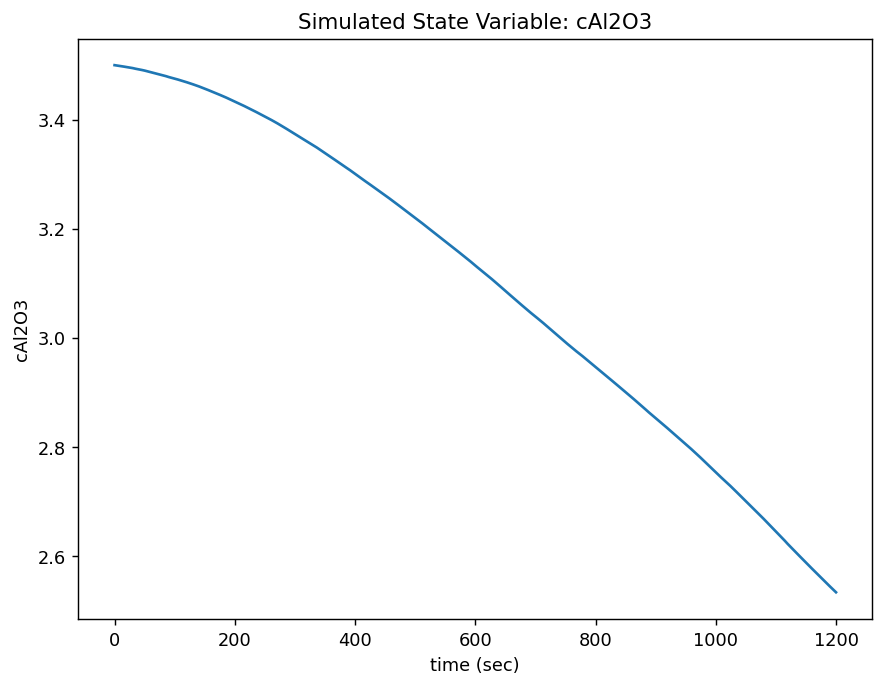

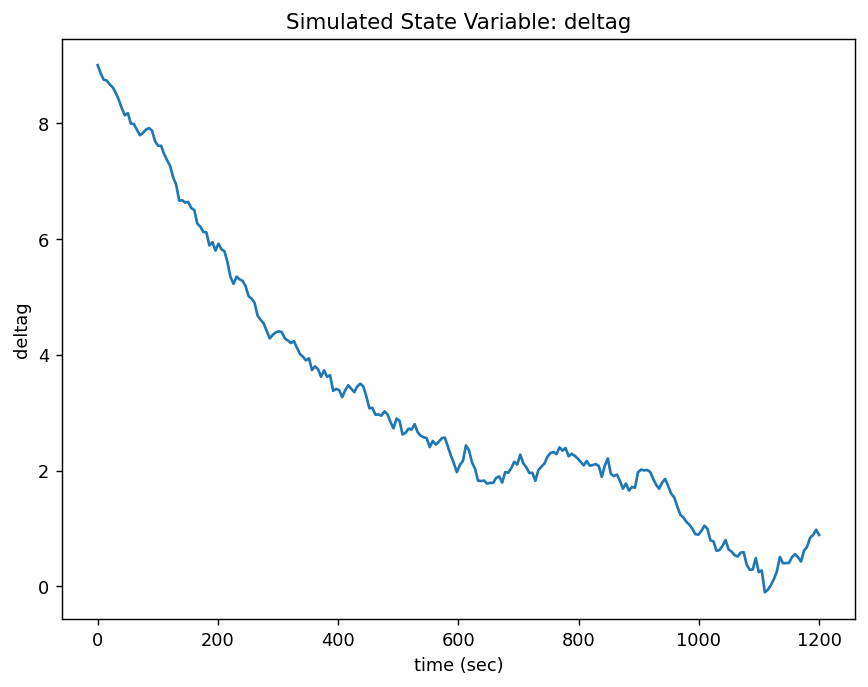

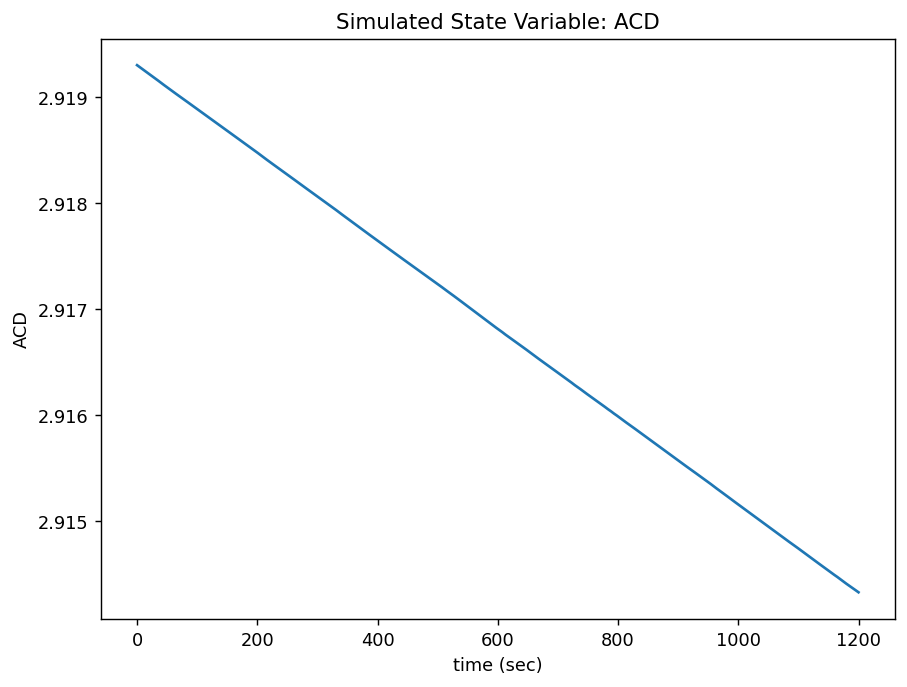

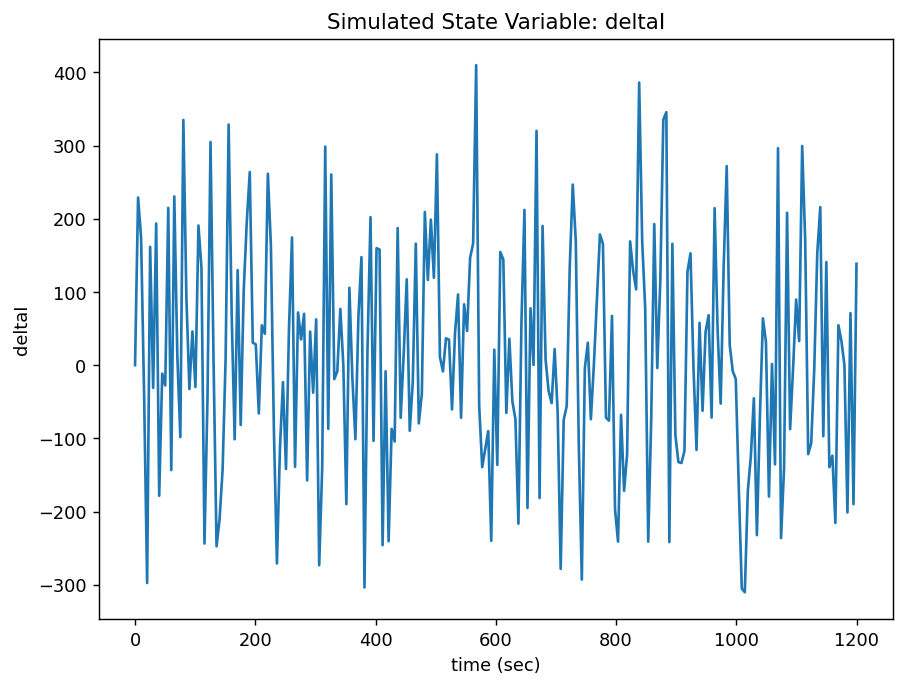

In [53]:
x, u = sim_nofeed(5, 240, bbcell, alumina4state, u0, x0, plotresult=True, statenoise=True)

### Response is more like the old 3 state model BUT
### now delta_g state is effectively the same as undissolved alumina...

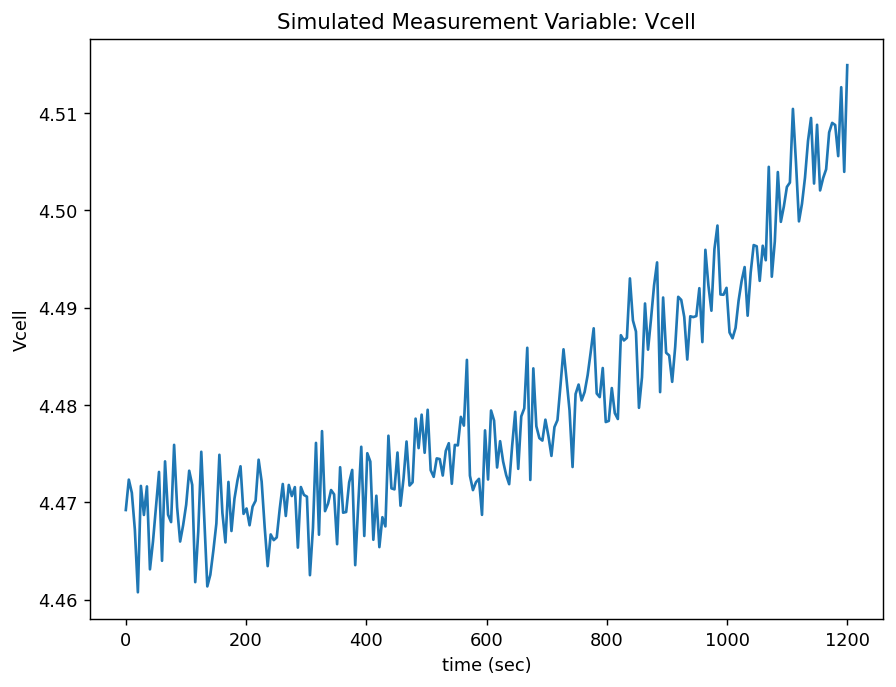

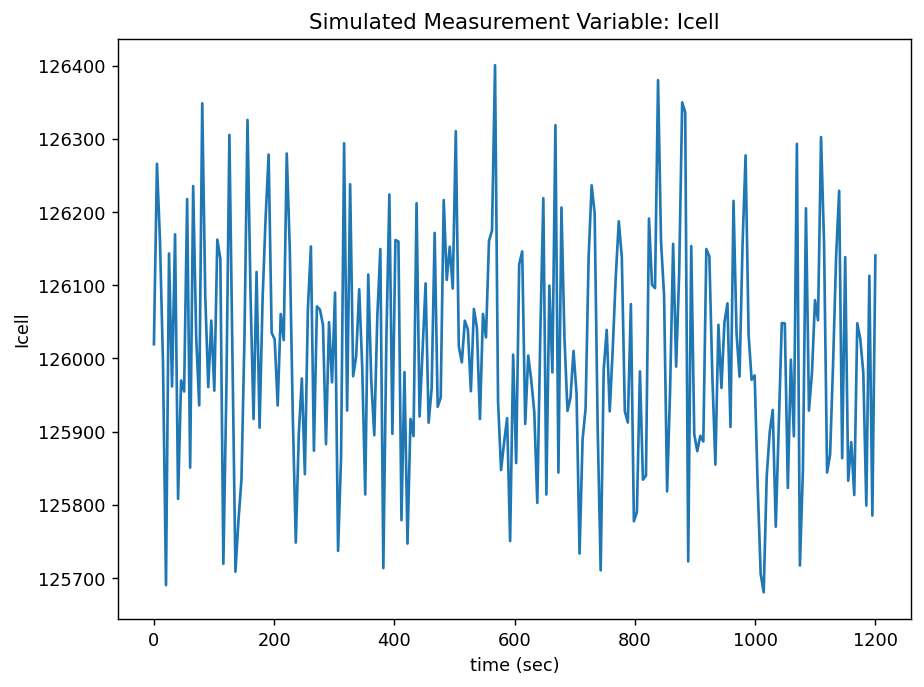

In [54]:
z = sim_observation(5, x, u, bbcell, alumina4state, plotresult=True)